In [13]:
from keras import backend as K
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Activation
from keras.layers import Reshape, Lambda
from keras.layers.merge import add, concatenate
from keras.models import Model
from keras.layers.recurrent import GRU
from keras.models import load_model
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np

Using TensorFlow backend.


In [14]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, :, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [15]:
def get_model(training,img_w,img_h,depth,alphabetLength,absolute_max_string_len):
    conv_filters = 16
    kernel_size = (3, 3)
    pool_size = 2
    time_dense_size = 32
    rnn_size = 512

    act='relu' #ReLU Activation function
    if K.image_data_format()=='channels_first':
      input_shape=(depth,img_w,img_h)
    else:
      input_shape=(img_w,img_h,depth)

    input_data=Input(name='the_input',shape=input_shape,dtype='float32')
    inner =Conv2D(conv_filters,kernel_size,padding='same',activation=act,
              kernel_initializer='he_normal',name='conv1')(input_data)

    inner =MaxPooling2D(pool_size=(pool_size,pool_size),name='max1')(inner)
    inner =Conv2D(conv_filters,kernel_size,padding='same',activation=act,
              kernel_initializer='he_normal',name='conv2')(inner)

    inner =MaxPooling2D(pool_size=(pool_size,pool_size),name='max2')(inner)
    conv_to_rnn_dims = (img_w // (pool_size**2),(img_h // (pool_size**2 )) * conv_filters)
    inner = Reshape(target_shape=conv_to_rnn_dims, name='reshape')(inner)
    inner = Dense(time_dense_size, activation=act, name='dense1')(inner)       

    gru_1 = GRU(rnn_size, return_sequences=True,
          kernel_initializer='he_normal', name='gru1')(inner)
    gru_1b = GRU(rnn_size, return_sequences=True,
           go_backwards=True, kernel_initializer='he_normal',
           name='gru1_b')(inner)
    gru1_merged = add([gru_1, gru_1b])

    gru_2 = GRU(rnn_size, return_sequences=True,
          kernel_initializer='he_normal', name='gru2')(gru1_merged)
    gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True,
           kernel_initializer='he_normal', name='gru2_b')(gru1_merged)

    # transforms RNN output to character activations:
    inner = Dense(alphabetLength, kernel_initializer='he_normal',name='dense2')(concatenate([gru_2, gru_2b]))
    y_pred = Activation('softmax', name='softmax')(inner)

    labels = Input(name='the_labels', shape=[absolute_max_string_len], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')

    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
    #chnage input shape for prediction
    if training:
        return Model(inputs=[input_data, labels, input_length, label_length], outputs=loss_out)
    else:
        return Model(inputs=[input_data], outputs=y_pred)

In [16]:
#Chnage Paramters as per your architecture
model = get_model(False,128,64,3,64,16)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


In [17]:
model.load_weights('ocr_best_weights.hdf5')

In [18]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 128, 64, 3)   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 64, 16)  448         the_input[0][0]                  
__________________________________________________________________________________________________
max1 (MaxPooling2D)             (None, 64, 32, 16)   0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 64, 32, 16)   2320        max1[0][0]                       
__________________________________________________________________________________________________
max2 (MaxP

In [20]:
# character classes 
alphabet = u'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789 '
def labels_to_text(labels):
    ret = []
    for c in labels:
        if c == len(alphabet):  # CTC Blank
            ret.append("")
        else:
            ret.append(alphabet[c])
    return "".join(ret)
def decode_predict_ctc(out, top_paths = 1):
    results = []
    beam_width = 10
    if beam_width < top_paths:
      beam_width = top_paths
    for i in range(top_paths):
      lables = K.get_value(K.ctc_decode(out, input_length=np.ones(out.shape[0])*out.shape[1],
                           greedy=False, beam_width=beam_width, top_paths=top_paths)[0][i])[0]
      text = labels_to_text(lables)
 
      results.append(text)
    return results

def test(modelPath,testPicTest):
    #img=cv2.imread(testPicTest,0) for gray images
    img=cv2.imread(testPicTest)
    img=cv2.resize(img,(128,64))
    plt.imshow(img, cmap='Greys_r')
    plt.show()
    img=img_to_array(img)
    img=np.array(img,dtype='float')/255.0
    img=np.expand_dims(img, axis=0)
    img=img.swapaxes(1,2)   
    
    net_out_value = modelPath.predict(img)
    top_pred_texts = decode_predict_ctc(net_out_value)
    return top_pred_texts

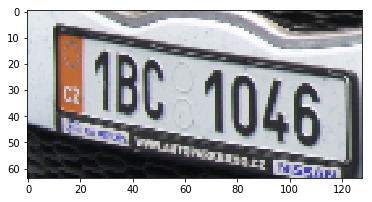

1BC1046 text
['1BC1046']


In [25]:
%matplotlib inline
test_image = '1BC1046.png'
print(test(model,test_image))

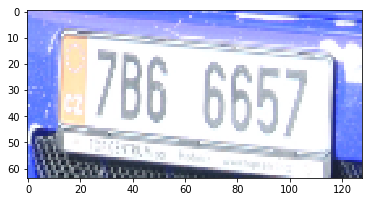

Predicted output: 7B657  


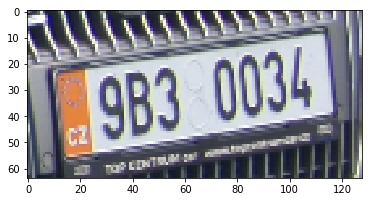

Predicted output: 9B3034 


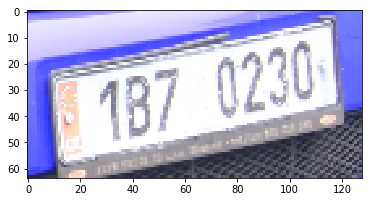

Predicted output: 1B70230


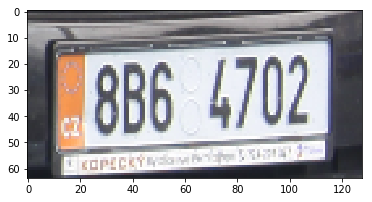

Predicted output: 8B64702


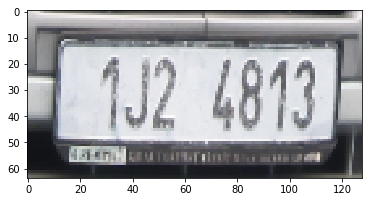

Predicted output: 1J24813


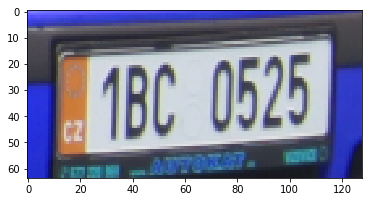

Predicted output: 1BC0525


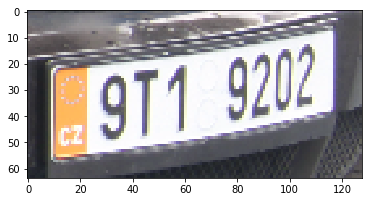

Predicted output: 9T19202


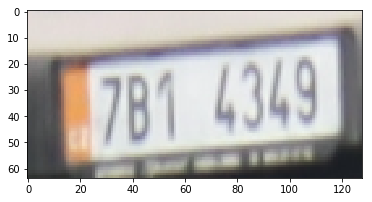

Predicted output: 7B14349


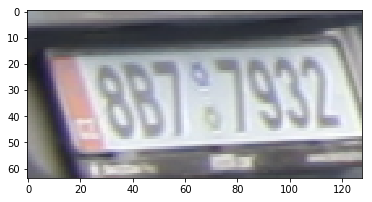

Predicted output: 8B7932 


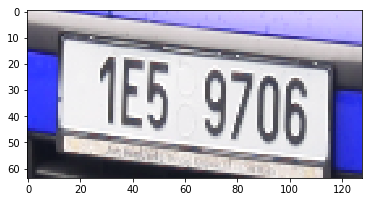

Predicted output: 1E59706


In [56]:
import os
import glob
from sklearn.metrics import accuracy_score
y_gt=[]
y_pred=[]
test_pics= glob.glob("./test/*")
c=0
for pic in test_pics:
    c+=1
    if c>10:
        break
    ground_truth= pic.rsplit("/",1)[1].split(".")[0]
    output= test(model,pic)[0]
    if len(output)!=len(ground_truth):
        left= 7-len(output)
        output+=" "*left
    y_gt.append(ground_truth)
    y_pred.append(output)        
    print("Predicted output:",output)
    gt_char=[]
    ot_char=[]
    for i in ground_truth:
        gt_char.extend(list(i))
    for j in output:
        ot_char.extend(list(j))
    
